In [1]:
from google.colab import drive
drive.mount('/content/drive')

#利用google drive將資料引入

Mounted at /content/drive


['dandelion', 'daisy', 'sunflower', 'rose', 'tulip']


Instructions for updating:
non-resource variables are not supported in the long term
100%|██████████| 764/764 [00:13<00:00, 57.07it/s] 


764


100%|██████████| 733/733 [00:12<00:00, 57.45it/s] 


1497


100%|██████████| 984/984 [00:15<00:00, 64.98it/s] 


2481


100%|██████████| 1052/1052 [00:18<00:00, 58.43it/s] 


3533


100%|██████████| 784/784 [00:14<00:00, 52.89it/s] 


4317


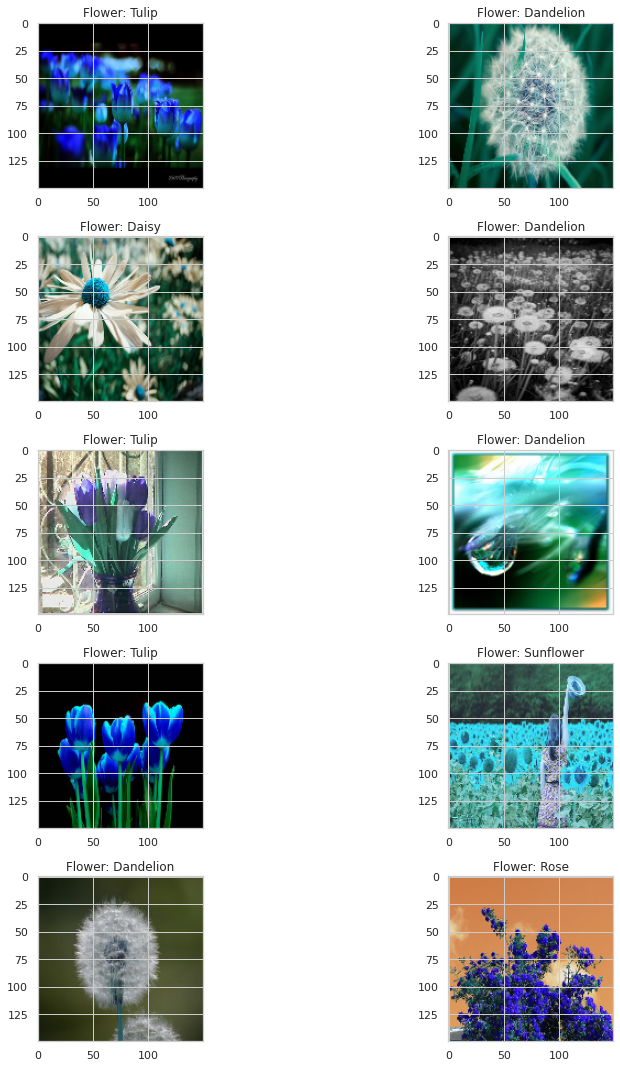

In [2]:
import os
print(os.listdir('drive/MyDrive/flowers'))

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.metrics import confusion_matrix

#2 ) Preparing the Data

#2.1) Making the functions to get the training and validation set from the Image

X=[]
Z=[]
IMG_SIZE=150   #設定圖片大小
FLOWER_DAISY_DIR='drive/MyDrive/flowers/daisy'    #尋找檔案路徑
FLOWER_SUNFLOWER_DIR='drive/MyDrive/flowers/sunflower'
FLOWER_TULIP_DIR='drive/MyDrive/flowers/tulip'
FLOWER_DANDI_DIR='drive/MyDrive/flowers/dandelion'
FLOWER_ROSE_DIR='drive/MyDrive/flowers/rose'

def assign_label(img,flower_type):
    return flower_type

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type) 
        path = os.path.join(DIR,img)  #連接兩個路徑名
        img = cv2.imread(path,cv2.IMREAD_COLOR) #讀取圖片，cv2.IMREAD_COLOR為預設值，這種格式會讀取 RGB 三個 channels 的彩色圖片，而忽略透明度的 channel。
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE)) #將圖片縮放成IMG_SIZE大小設定為150  
        
        X.append(np.array(img)) 
        Z.append(str(label))

make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

fig,ax=plt.subplots(5,2)  #設定做一個5,2的表格圖
fig.set_size_inches(15,15)    #每一個的size為`15,15`的大小
for i in range(5):        #在title上說明這是哪一種花隨後印出來，就會看到前10筆(5*2=10)的結果
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()  #可以將每張子圖都考量到 X、Y軸上的值與標籤，給予適當的距離。

# Y將Z變成One hot encoding，原本Z[3] = 'Tulip'就轉變成Y[3] = [0,0,1,0,0]。

le=LabelEncoder()    #把每個類別mapping到某個整數，不會增加新欄位
Y=le.fit_transform(Z)   #先進行fit再進行transform，即把z塞到字典中去以後再進行transform得到索引值。
Y=to_categorical(Y,5)    #to_categorical就是將類別向量轉換為二進制（只有0和1）的矩陣類型表示
X=np.array(X)   #一維陣列建立
X=X/255   #X=X/255是因為RGB值域為0~255，這裡標準化為0~1 ，可提昇模型預測的準確度，梯度運算時也能更快收斂。


x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
#將資料切成 Training data （訓練資料） 以及 Test data （測試資料），test的比例為25%
#因為採隨機的切法，這裡設定seed為42(只要是相同的亂數種子，取出的樣本集合都一樣)，以免重新訓練時train、test又變得不一樣。

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)
#這裡也設定好np、rn、tf等各種數學運算的亂數種子皆為42，因為在深度學習的模型中，AI最一開始的模型裡面的矩陣都是亂數，這裡為追求每次訓練的起始值一樣，因此固定種子


#建立CNN模型
model = Sequential()  #先建立一個Sequential模型

# input_shape 讓輸入的影像有一致的格式，程式中的 3 是指 R/B/G 三個通道
# activation function 設定為 ReLU
# MaxPooling，作用是降躁跟減少運算資源，設為 2 * 2 尺寸
# pool_size：池化視窗的大小，通常設為2，效果就不錯。
# strides：滑動步長，計算滑動視窗時移動的格數。

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())  #Flatten層用於將多維輸入變成一維，常用於從卷積層到全連接層的過渡。
model.add(Dense(512)) #Dense(512) 是一個具有512個隱藏神經元的全連接層
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

      

In [3]:
datagen.fit(x_train)

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

In [4]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),     #開始訓練
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/50
25/25 [==============================] - 22s 479ms/step - batch: 12.0000 - size: 124.3600 - loss: 1.5510 - acc: 0.3004 - val_loss: 1.3370 - val_acc: 0.4176
Epoch 2/50
25/25 [==============================] - 17s 723ms/step - batch: 12.0000 - size: 124.3600 - loss: 1.2604 - acc: 0.4487 - val_loss: 1.1187 - val_acc: 0.5204
Epoch 3/50
25/25 [==============================] - 19s 760ms/step - batch: 12.0000 - size: 124.3600 - loss: 1.1368 - acc: 0.5269 - val_loss: 0.9934 - val_acc: 0.5991
Epoch 4/50
25/25 [==============================] - 20s 774ms/step - batch: 12.0000 - size: 128.0000 - loss: 1.0393 - acc: 0.5922 - val_loss: 1.1335 - val_acc: 0.5343
Epoch 5/50
25/25 [==============================] - 18s 748ms/step - batch: 12.0000 - size: 124.3600 - loss: 1.0093 - acc: 0.5995 - val_loss: 0.9378 - val_acc: 0.6194
Epoch 6/50
25/25 [==============================] - 17s 677ms/step - batch: 12.0000 - size: 120.7200 - loss: 0.9490 - acc: 0.6213 - val_loss: 0.9234 - val_acc: 0.635

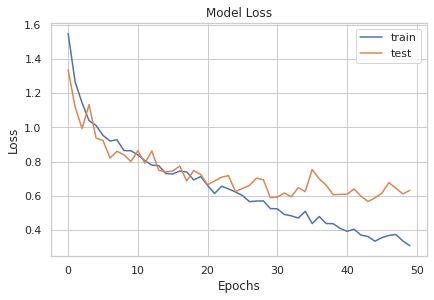

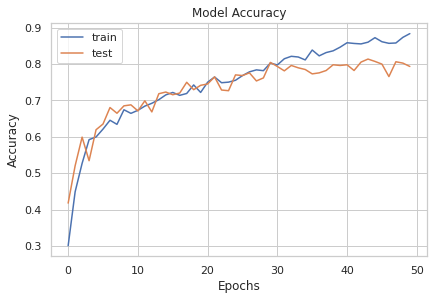

[2 4 4 ... 3 3 2]
[2 4 4 ... 3 1 2]
0.8997555012224939 0.918552036199095 0.8982300884955752 0.9082774049217003


In [16]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show() 

#show出結果中每個Epoch的train的loss與test的val_loss值


plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show() 

#show出結果中每個Epoch的train的acc(精準度)與test的val_acc值

pred=model.predict(x_test).round()
pred_digits=np.argmax(pred,axis=1)
expect_digits=np.argmax(y_test, axis=1)

print(expect_digits)
print(pred_digits)


tn, fp, fn, tp = confusion_matrix(expect_digits, pred_digits,labels=[0,1]).ravel()
#透過混淆矩陣取得四個回傳值來計算性能指標Accuracy , Precision , Recall , F1

Accuracy = (tp+tn)/(tp+fp+fn+tn)   #預測正確的比率，即猜對的個數(tp+tn)/全部樣本數。
Precision = tp/(tp+fp)     #即陽性的樣本中有幾個是預測正確的。
Recall = tp/(tp+fn)      #即事實為真的樣本中有幾個是預測正確的。
F1 = 2 / ( (1/ Precision) + (1/ Recall) )     #即精確率與召回率的調和平均數。

print(Accuracy , Precision , Recall , F1)
